In [32]:
import sys

# Set the sys path to the main directory of the project
MAIN_DICT = "/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability"
sys.path.append(MAIN_DICT)

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.utils.data as data

from utils.load import load_data
from utils.params import set_param

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error


# Params for downsampling (specific to the dataset)
WINDOW = int(1e3) # use 1e2
STEP = int(1e3) # use 1e2

LOOKBACK_SEC = 20
FORECAST_SEC = 5

BATCH_SIZE = 32
EPOCHS = 500

# Set torch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


In [34]:
# exp = 'b726'
# exp = 'b698'
# exp = 'i417'
# exp = 'p4679'
exp = "p4581"
# exp = 'cascadia'
# exp = 'sim_b726'
# exp = 'sim_b698'
# exp = 'sim_i417'

# TODO: De-trend only on train data and not the full dataset (else data leakage)
# Modify the load_data function to return raw data, split into train and test and then detrend the train data

params = set_param(exp)

dirs = {"main": MAIN_DICT}
dirs["data"] = dirs["main"] + "/data/" + params["dir_data"]

X, _, t, _, _ = load_data(exp, dirs, params)

# Put the detrended shear stress (X) and time (t) into a pandas dataframe allows
# us to work with it more easily and carry out downsampling

# In numpy, the shape of an array is a tuple that gives the size of each 
# dimension. The shape `(200010, 1)` means that the array `X` is a 2D array with
# 200010 rows and 1 column. The shape `(200010,)` means that the array `t` is a 
# 1D array with 200010 elements. The trailing comma is used to indicate that 
# this is a tuple with one element. In other words, `t` is a 1D array (like a 
# list), while `X` is a 2D array (like a list of lists, where each inner list 
# has only one element).

print(X.shape)
print(t.shape)

# `t.reshape(-1, 1)` is reshaping the `t` array. The `-1` in reshape function is
# a placeholder for "figure out what the dimension should be based on the length
# of the array and the other dimensions". The `1` means we want `t` to have one
# column. So, `t.reshape(-1, 1)` is reshaping `t` to have one column and as many
# rows as needed to accommodate the data.

# We need to reshape `t` because `np.hstack` requires the arrays of the same 
# dimensions.

# `np.hstack` horizontally stacks multiple arrays. In this case, it's stacking 
# the arrays `X` and `t.reshape(-1, 1)` side by side. The result is a single 2D 
# array where the first columns are from `X` and the last column is from `t`.

# The resulting 2D array is then turned into a pandas DataFrame, which is a 2D 
# labeled data structure with columns of potentially different types.
ts_data = pd.DataFrame(np.hstack((X, t.reshape(-1, 1))), columns=["X", "t"])

ts_data.head()

(200010, 1)
(200010,)


,X,t
0,1.29911,0.000
1,1.29903,0.001
2,1.29853,0.002
3,1.29871,0.003
4,1.29854,0.004


Sample rate: 999.9950002499876 Hz


Text(0.5, 1.0, 'Shear stress vs time')

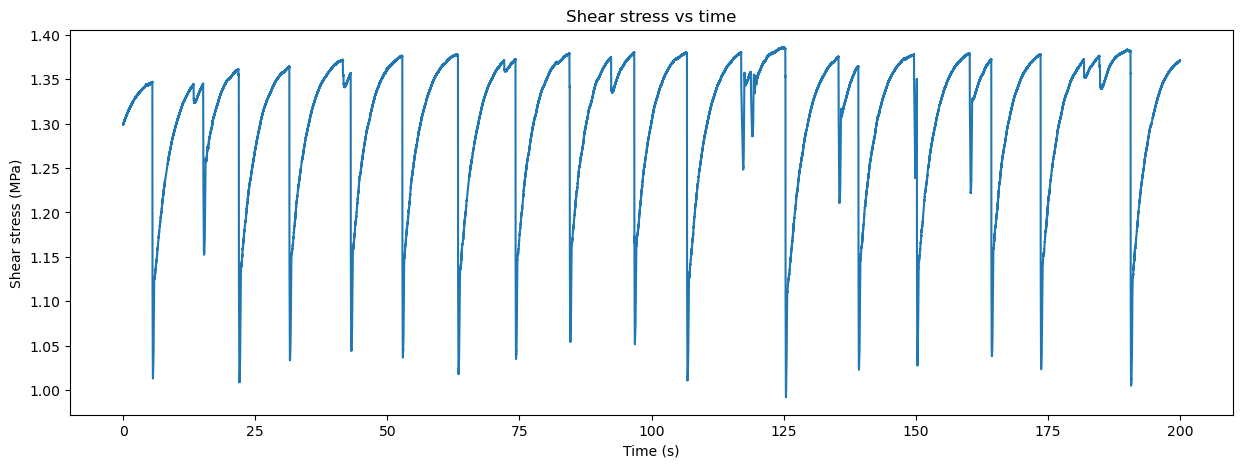

In [35]:
SECONDS_TO_DISPLAY = 200

# Compute the sample rate from the time data
sample_rate = 1 / np.mean(np.diff(ts_data["t"]))
print("Sample rate:", sample_rate, "Hz")

# Sample rate as an interger (round to nearest integer)
sample_rate = int(np.round(sample_rate))

segment_in_sec = sample_rate * SECONDS_TO_DISPLAY

plt.figure(figsize=(15, 5))
plt.plot(ts_data["t"][:segment_in_sec], ts_data["X"][:segment_in_sec])
plt.xlabel("Time (s)")
plt.ylabel("Shear stress (MPa)")
plt.title("Shear stress vs time")

# Not plotting derivative and log derivative for now as signal is too noisy at 
# this stage

Sample rate: 0.9999950002499877 Hz


Text(0.5, 1.0, 'De-noised de-trended shear stress vs time')

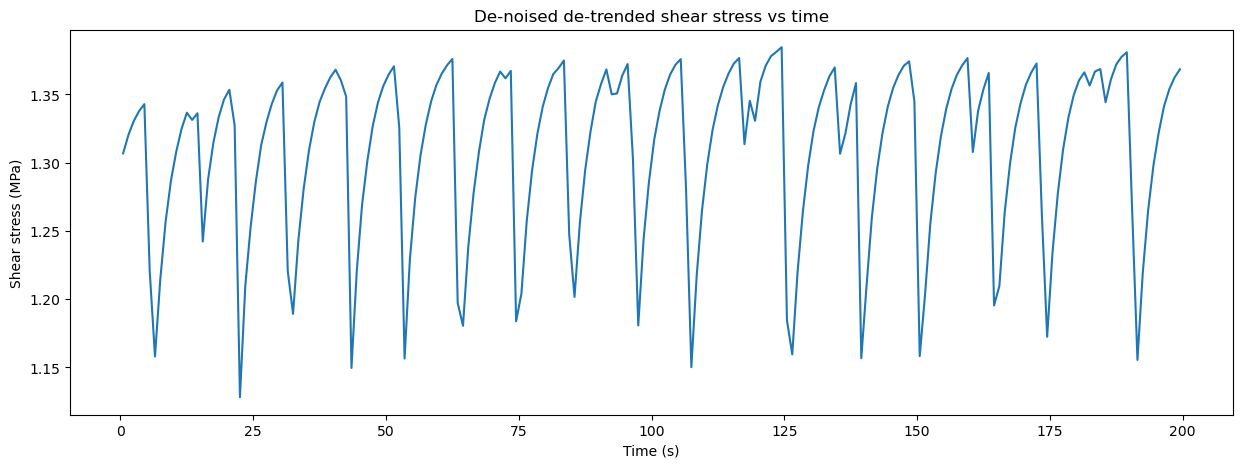

In [36]:
# Downsample to remove noise (smoothing) and make forecasting easier (less 
# points to predict)

# Apply a rolling window function with a specific window size and step size, 
# then calculate the mean for each window. This is a way of downsampling the 
# data, reducing its size and smoothing out short-term fluctuations.
# The dropna() function is used to remove any resulting missing values.
ts_data = ts_data.rolling(window=WINDOW, step=STEP).mean().dropna()

# Reset the index of the DataFrame. The 'drop=True' argument is used to avoid 
# the old index being added as a column.
ts_data = ts_data.reset_index(drop=True)

# TODO: Wrap this in a util function
# Compute the sample rate from the time data post downsampling
sample_rate = 1 / np.mean(np.diff(ts_data["t"]))
print("Sample rate:", sample_rate, "Hz")

# Sample rate as an interger rounded to nearest integer
sample_rate = int(np.round(sample_rate))

segment_in_sec = sample_rate * SECONDS_TO_DISPLAY

# Plot the downsampled data
plt.figure(figsize=(15, 5))
plt.plot(ts_data["t"][:segment_in_sec], ts_data["X"][:segment_in_sec])
plt.xlabel("Time (s)")
plt.ylabel("Shear stress (MPa)")
plt.title("De-noised de-trended shear stress vs time")

Text(0.5, 1.0, 'Scaled de-noised de-trended shear stress vs time')

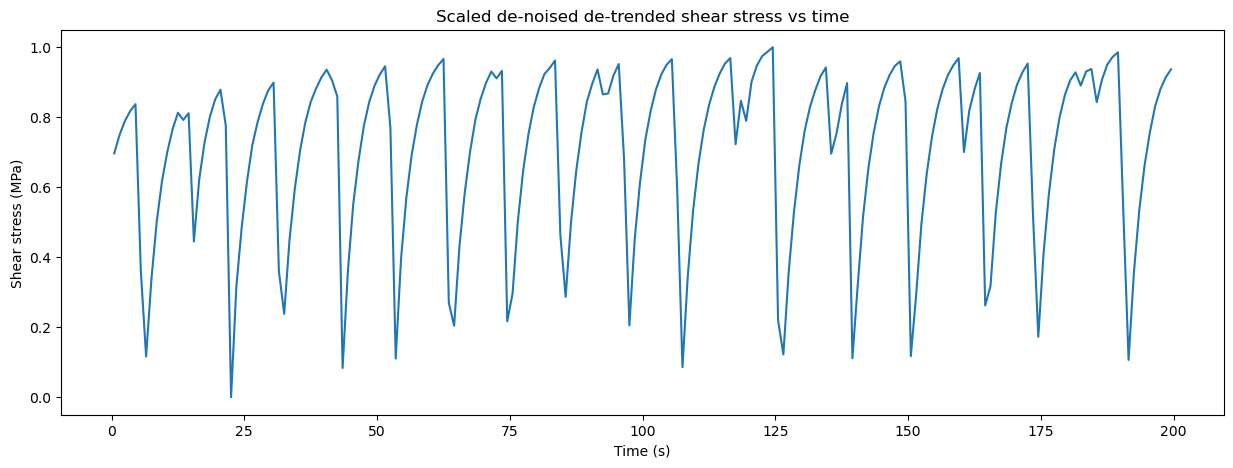

In [37]:
# Do min/max scaling (normalisation) of the shear stress data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(ts_data["X"].values.reshape(-1, 1)).flatten()

# Plot the scaled data
plt.figure(figsize=(15, 5))
plt.plot(ts_data["t"][:segment_in_sec], X_scaled[:segment_in_sec])
plt.xlabel("Time (s)")
plt.ylabel("Shear stress (MPa)")
plt.title("Scaled de-noised de-trended shear stress vs time")

In [58]:
lookback = LOOKBACK_SEC * sample_rate
forecast = FORECAST_SEC * sample_rate

def create_dataset_random_index(X, lookback, forecast, batch_samples, train_val_test_split=(0.7, 0.2, 0.1)):
    """
    Create X_train, y_train, X_val, y_val, X_test, y_test datasets from X
    X_train is a collection of samples of length lookback
    y_train is a collection of samples of length forecast

    # Train test sample generation strategy:
    # 1. Generate a random start index
    # 2. Generate a sample of length LOOKBACK starting from the random start index
    # 3. Generate a sample of length FORECAST starting from the random start index + LOOKBACK
    # 4. Repeat 1-3 until we have BATCH_SAMPLES samples
    """
    samples = BATCH_SIZE * batch_samples # nb. samples factor of the batch size to fit into batches

    print("Number of samples:", samples)

    # Create a array of random start indices of size samples
    start_idx = np.random.randint(0, len(X_scaled) - lookback - forecast, size=samples)

    X_train = []
    y_train = []
    X_val = []
    y_val = []
    X_test = []
    y_test = []

    # Check that the train_val_test_split adds up to 1
    # assert sum(train_val_test_split) == 1

    # Calculate the second derivative of X (passed at the second input to the model)
    X_derivative = np.gradient(np.gradient(X))

    # Split into train, validation and test sets
    train_size = int(len(start_idx) * train_val_test_split[0])
    
    val_size = int(len(start_idx) * train_val_test_split[1])
    train_idx = start_idx[:train_size]
    val_idx = start_idx[train_size:train_size + val_size]
    test_idx = start_idx[train_size + val_size:]

    # Create X_train and y_train
    for idx in train_idx:
        X_train.append(np.column_stack((X[idx : idx + lookback], X_derivative[idx : idx + lookback])))
        y_train.append(X[idx + lookback : idx + lookback + forecast])

    # Create X_val and y_val
    for idx in val_idx:
        X_val.append(np.column_stack((X[idx : idx + lookback], X_derivative[idx : idx + lookback])))
        y_val.append(X[idx + lookback : idx + lookback + forecast])

    # Create X_test and y_test
    for idx in test_idx:
        X_test.append(np.column_stack((X[idx : idx + lookback], X_derivative[idx : idx + lookback])))
        y_test.append(X[idx + lookback : idx + lookback + forecast])

    # Convert to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_val = np.array(X_val)
    y_val = np.array(y_val)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    return X_train, y_train, X_val, y_val, X_test, y_test

# TODO: Understand this function better 
def create_dataset_rolling_window(data, lookback, forecast, train_val_test_split=(0.7, 0.2, 0.1)):
    xs, ys = [], []
    data_derivative = np.gradient(np.gradient(data))  # Calculate the second derivative of data

    for i in range(len(data) - lookback - forecast - 1):
        x = np.column_stack((data[i : (i + lookback)], data_derivative[i : (i + lookback)]))  # Append the second derivative to x
        y = data[(i + lookback) : (i + lookback + forecast)]
        xs.append(x)
        ys.append(y)

    # Convert to numpy arrays
    xs = np.array(xs)
    ys = np.array(ys)

    # Calculate the sizes of the train, validation, and test sets
    train_size = int(len(xs) * train_val_test_split[0])
    val_size = int(len(xs) * train_val_test_split[1])

    # Split the data into train, validation, and test sets
    X_train, y_train = xs[:train_size], ys[:train_size]
    X_val, y_val = xs[train_size:train_size + val_size], ys[train_size:train_size + val_size]
    X_test, y_test = xs[train_size + val_size:], ys[train_size + val_size:]

    return X_train, y_train, X_val, y_val, X_test, y_test

# X_train, y_train, X_val, y_val, X_test, y_test = create_dataset_random_index(X_scaled, lookback, forecast, 10)
X_train, y_train, X_val, y_val, X_test, y_test = create_dataset_rolling_window(X_scaled, lookback, forecast)

print("Number of training samples:", len(X_train))
print("Number of validation samples:", len(X_val))
print("Number of test samples:", len(X_test))

Number of training samples: 121
Number of validation samples: 34
Number of test samples: 19


Text(0.5, 1.0, 'X and y samples')

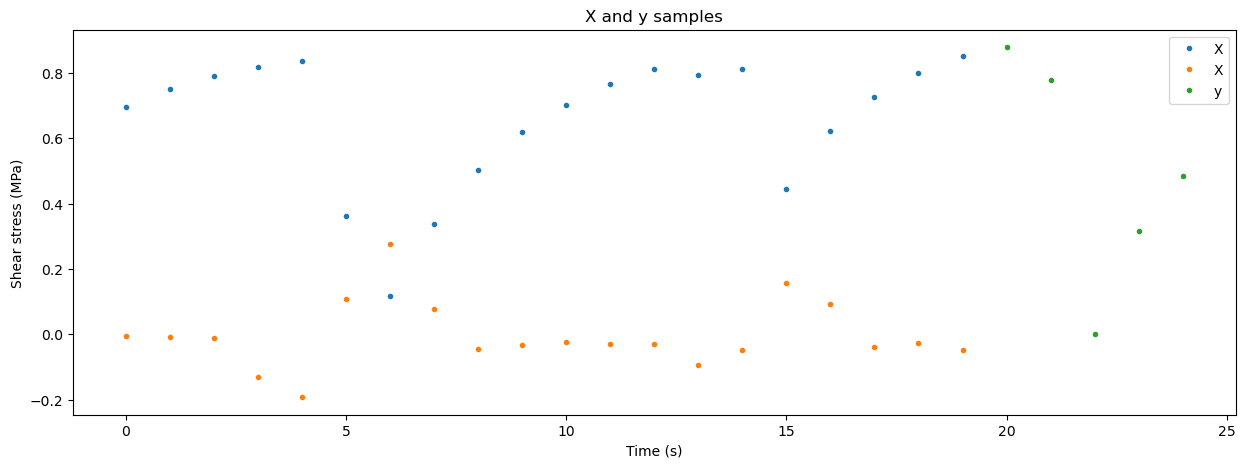

In [43]:
# Plot an example X and y sample
plt.figure(figsize=(15, 5))
plt.plot(X_train[0], ".", label="X")
# Plot the y sample shifted by the length of the lookback
plt.plot(np.arange(lookback, lookback + forecast), y_train[0], ".", label="y")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Shear stress (MPa)")
plt.title("X and y samples")

In [44]:
# LSTM model to carry out multi-step forecasting along forecast
# input: [batch size, lookback, 1]
# output: [batch size, forecast, 1]

# Input: batch of samples, each of length lookback
# Output: batch of samples, each of length forecast
# Model: LSTM that takes lookback samples and outputs forecast samples

class LSTM(nn.Module):
    def __init__(self, input_size=2, hidden_layer_size=100, output_size=forecast):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)

        # Fully connected layer
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        # Initialise hidden state and cell state
        h0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size).to(device)
        c0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size).to(device)

        # LSTM layer
        lstm_out, _ = self.lstm(input_seq, (h0, c0))

        # Only take the output from the final timestep
        predictions = self.linear(lstm_out[:, -1, :])

        return predictions

In [45]:
# Train the model
model = LSTM().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Size of X_train and y_train is [nb. samples, lookback]
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Convert X_train and y_train to tensors (currently numpy arrays)
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)

# Convert val to tensors
X_val = torch.from_numpy(X_val)
y_val = torch.from_numpy(y_val)

# data loader
test_loader = data.DataLoader(
    data.TensorDataset(X_train, y_train), batch_size=BATCH_SIZE
)

# val loader
val_loader = data.DataLoader(
    data.TensorDataset(X_val, y_val), batch_size=BATCH_SIZE
)

# FIXME: Should I design my model to input output (batch_size, lookback/forecast, 1) or (batch_size, lookback/forecast) and then reshape in the forward pass?

# Train the model for EPOCHS, show the train and validation loss
train_losses = []
val_losses = []
for epoch in range(EPOCHS):
    model.train()
    batch_losses = []
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(x_batch.float())
        loss = loss_function(y_pred, y_batch.float())
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
    train_losses.append(np.mean(batch_losses))

    # Validation loss
    model.eval()
    batch_losses = []
    for x_batch, y_batch in val_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_pred = model(x_batch.float())
        loss = loss_function(y_pred, y_batch.float())
        batch_losses.append(loss.item())
    val_losses.append(np.mean(batch_losses))

    if epoch % 10 == 0:
        print(f"Epoch {epoch} train loss: {train_losses[-1]} val loss: {val_losses[-1]}")

X_train shape: (121, 20, 2)
y_train shape: (121, 5)
Epoch 0 train loss: 0.547721654176712 val loss: 0.40322428941726685
Epoch 10 train loss: 0.06941177323460579 val loss: 0.06965611129999161
Epoch 20 train loss: 0.06440318655222654 val loss: 0.06825333088636398
Epoch 30 train loss: 0.0625545121729374 val loss: 0.06594543717801571
Epoch 40 train loss: 0.06015344522893429 val loss: 0.0629054568707943
Epoch 50 train loss: 0.055736093781888485 val loss: 0.057793525978922844
Epoch 60 train loss: 0.04508055094629526 val loss: 0.042769720777869225
Epoch 70 train loss: 0.040903066750615835 val loss: 0.038268860429525375
Epoch 80 train loss: 0.039657946676015854 val loss: 0.03643609583377838
Epoch 90 train loss: 0.038493636064231396 val loss: 0.034719137474894524
Epoch 100 train loss: 0.03725569834932685 val loss: 0.03276925440877676
Epoch 110 train loss: 0.03591783484444022 val loss: 0.03035986702889204
Epoch 120 train loss: 0.03446627454832196 val loss: 0.027362240478396416
Epoch 130 train lo

In [46]:
# Test the model
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

# data loader
test_loader = data.DataLoader(
    data.TensorDataset(X_test, y_test), batch_size=BATCH_SIZE
)

yb_list = []
output_list = []

model.eval()

for xb, yb in test_loader:
    yb_list.append(yb)
    
    # Forward pass
    output = model(xb.float().to(device))
    output_list.append(output.detach().cpu().numpy())

    # Calculate loss
    loss = loss_function(output, yb.float().to(device))
    print(f"Loss: {loss.item()}")

# R2
yb_list = np.array(yb_list).flatten()
output_list = np.array(output_list).flatten()
r2_score(yb_list, output_list)
mean_squared_error(yb_list, output_list)

Loss: 0.04148238152265549


0.04148237819950437

torch.Size([1, 5])


Text(0.5, 1.0, 'Forecast vs actual on first sample from test set')

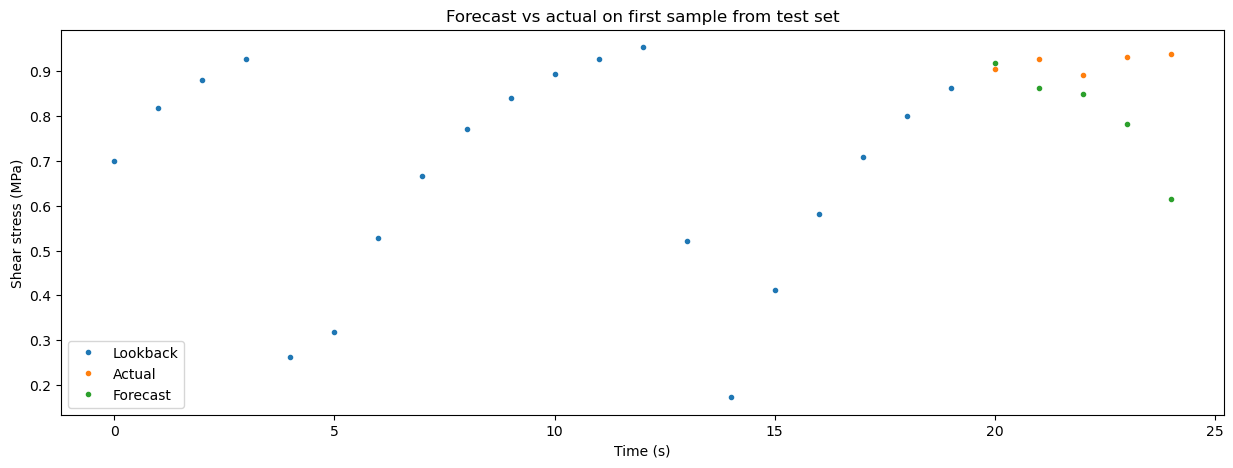

In [52]:
# Do a single forward pass on the first sample from the test set
random_test_idx = np.random.randint(0, len(X_test))
first_sample = X_test[random_test_idx].unsqueeze(0).float().to(device)  # Removed unsqueeze(2)
output = model(first_sample)
print(output.shape)

# Plot forecast vs actual on first sample from test set
plt.figure(figsize=(15, 5))
# Plot the lookback
plt.plot(np.arange(lookback), X_test[random_test_idx, :, 0], ".", label="Lookback")  # Select only time series values
plt.plot(np.arange(lookback, lookback + forecast), y_test[random_test_idx], ".", label="Actual")
plt.plot(np.arange(lookback, lookback + forecast), output.detach().cpu().numpy()[0], ".", label="Forecast")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Shear stress (MPa)")
plt.title("Forecast vs actual on first sample from test set")